<a href="https://colab.research.google.com/github/aruunsriram/TNSDC/blob/main/Updated_Distracted_Driver_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install np_utils
!pip install plot_model
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=eac154a0e01ad515f2c48f4d8b06df4d283e8fbc990d3cfba61e515745d49635
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tqdm import tqdm

from keras.applications.mobilenet_v2 import MobileNetV2

# Importing the dataset

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elyeskhechine","key":"fb99a648914cab6d962cf8d007181372"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.98G/4.00G [00:43<00:00, 140MB/s]
100% 4.00G/4.00G [00:43<00:00, 98.2MB/s]


In [ ]:
from zipfile import ZipFile
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Extract the downloaded dataset zip file
with ZipFile("state-farm-distracted-driver-detection.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [ ]:
# Load the driver_imgs_list.csv file
driver_csv_path = "driver_imgs_list.csv"
train_df = pd.read_csv(driver_csv_path)

In [ ]:
train_df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [ ]:
TRAIN_DIR = os.path.join(os.getcwd(), "imgs", "train")
TEST_DIR = os.path.join(os.getcwd(), "imgs", "test")

In [ ]:
def create_test_dataframe(test_dir):
    # Get the list of test images
    test_images = os.listdir(test_dir)

    # Extract subject, classname, and img information
    subjects = ['unknown'] * len(test_images)
    classnames = ['unknown'] * len(test_images)
    img_names = test_images

    # Create the DataFrame
    data_test = pd.DataFrame({'subject': subjects, 'classname': classnames, 'img': img_names})

    return test_df

In [ ]:
test_df = create_test_dataframe(TEST_DIR)

In [ ]:
test_df

,subject,classname,img
0,unknown,unknown,img_30006.jpg
1,unknown,unknown,img_92517.jpg
2,unknown,unknown,img_54429.jpg
3,unknown,unknown,img_101039.jpg
4,unknown,unknown,img_67763.jpg
...,...,...,...
79721,unknown,unknown,img_72314.jpg
79722,unknown,unknown,img_28327.jpg
79723,unknown,unknown,img_52993.jpg
79724,unknown,unknown,img_58942.jpg


In [ ]:
# Create csv_files directory
CSV_DIR = os.path.join(os.getcwd(), "csv_files")
os.makedirs(CSV_DIR, exist_ok=True)

# Create CSV files for train and test
train_df.to_csv(os.path.join(CSV_DIR, "train.csv"), index=False)
test_df.to_csv(os.path.join(CSV_DIR, "test.csv"), index=False)

In [ ]:
train_df['classname'] = train_df['classname'].astype(str).str.extract('(\d+)').astype(int)

In [ ]:
train_df

,subject,classname,img
0,p002,0,img_44733.jpg
1,p002,0,img_72999.jpg
2,p002,0,img_25094.jpg
3,p002,0,img_69092.jpg
4,p002,0,img_92629.jpg
...,...,...,...
22419,p081,9,img_56936.jpg
22420,p081,9,img_46218.jpg
22421,p081,9,img_25946.jpg
22422,p081,9,img_67850.jpg


In [ ]:
# Create a list of label IDs
labels_list = list(set(train_df['classname'].values.tolist()))
labels_id = {label_name: id for id, label_name in enumerate(labels_list)}
print(labels_id)
labels = to_categorical(train_df['classname'])
print(labels.shape)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
(22424, 10)


In [ ]:
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)
with open(os.path.join(PICKLE_PATH,"labels_list_mobilenetv2.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
# Split train_df into train_set and validation_set
training_set, validation_set,training_labels,validation_labels = train_test_split(train_df,labels,test_size = 0.2,random_state=42)
# Display the shapes of the sets
print("Train set shape:", training_labels.shape)
print("Validation set shape:", validation_labels.shape)

Train set shape: (17939, 10)
Validation set shape: (4485, 10)


In [ ]:
training_features=training_set.iloc[:,0]
training_features

14217    p049
8980     p026
2129     p014
2414     p014
2794     p015
         ... 
11964    p045
21575    p075
5390     p021
860      p012
15795    p051
Name: subject, Length: 17939, dtype: object

In [ ]:
validation_features=validation_set.iloc[:,0]
validation_features

12922    p047
17403    p056
7648     p024
15371    p051
9213     p026
         ... 
6492     p022
19299    p064
19472    p066
14384    p049
10690    p039
Name: subject, Length: 4485, dtype: object

In [ ]:
training_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
validation_labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
# Paths to tensor for the training set
train_image_paths = [os.path.join(TRAIN_DIR, f'c{classname}', img) for classname, img in zip(training_set['classname'], training_set['img'])]
train_tensors = paths_to_tensor(train_image_paths)

100%|██████████| 17939/17939 [00:40<00:00, 441.60it/s]


In [ ]:
# Paths to tensor for the validation set
validation_image_paths = [os.path.join(TRAIN_DIR, f'c{classname}', img) for classname, img in zip(validation_set['classname'], validation_set['img'])]
validation_tensors = paths_to_tensor(validation_image_paths)

100%|██████████| 4485/4485 [00:09<00:00, 449.12it/s]


In [ ]:
# Image normalization
train_tensors = train_tensors.astype('float32') / 255 - 0.5
validation_tensors = validation_tensors.astype('float32') / 255 - 0.5

# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of MobileNetV2 model
2. Using the n-1 layers of MobileNetV2 to predict the last layer of it using the flattened image vector
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [ ]:
model = MobileNetV2(include_top=False)
model.summary()

Model: "mobilenetv2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   

In [ ]:
train_mobilenetv2 = model.predict(train_tensors,verbose=1)
valid_mobilenetv2 = model.predict(validation_tensors,verbose=1)

141/141 [==============================] - 196s 1s/step


In [ ]:
print("Train shape",train_mobilenetv2.shape)
print("Validation shape",valid_mobilenetv2.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [ ]:
train_features = train_mobilenetv2[0]
valid_features = valid_mobilenetv2[0]

In [ ]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [ ]:
MobileNetV2_model = Sequential()
MobileNetV2_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
MobileNetV2_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

MobileNetV2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 5130 (20.04 KB)
Trainable params: 5130 (20.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
MobileNetV2_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
from keras.utils import plot_model
MODEL_PATH = os.path.join(os.getcwd(),"model","mobilenetv2")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)

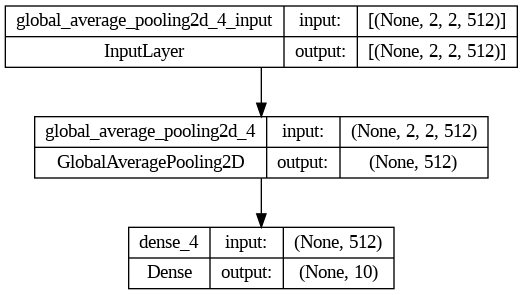

In [ ]:
plot_model(MobileNetV2_model,to_file=os.path.join(os.getcwd(),"model","mobilenetv2","model_distracted_driver_mobilenetv2.png"),show_shapes=True,show_layer_names=True)

In [ ]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_freq='epoch')
callbacks_list = [checkpoint]

In [ ]:
model_history = MobileNetV2_model.fit(train_mobilenetv2,training_labels,validation_data = (valid_mobilenetv2, validation_labels),epochs=400, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/400
1109/1122 [============================>.] - ETA: 0s - loss: 1.7677 - accuracy: 0.4496
Epoch 1: val_accuracy improved from -inf to 0.58640, saving model to /content/model/mobilenetv2/distracted-01-0.59.hdf5
1122/1122 [==============================] - 3s 2ms/step - loss: 1.7643 - accuracy: 0.4510 - val_loss: 1.4464 - val_accuracy: 0.5864
Epoch 2/400
  59/1122 [>.............................] - ETA: 1s - loss: 1.3950 - accuracy: 0.6017

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1119/1122 [============================>.] - ETA: 0s - loss: 1.2577 - accuracy: 0.6561
Epoch 2: val_accuracy improved from 0.58640 to 0.68785, saving model to /content/model/mobilenetv2/distracted-02-0.69.hdf5
1122/1122 [==============================] - 2s 2ms/step - loss: 1.2572 - accuracy: 0.6562 - val_loss: 1.1399 - val_accuracy: 0.6878
Epoch 3/400
1101/1122 [============================>.] - ETA: 0s - loss: 1.0356 - accuracy: 0.7196
Epoch 3: val_accuracy improved from 0.68785 to 0.72776, saving model to /content/model/mobilenetv2/distracted-03-0.73.hdf5
1122/1122 [==============================] - 3s 3ms/step - loss: 1.0355 - accuracy: 0.7194 - val_loss: 0.9776 - val_accuracy: 0.7278
Epoch 4/400
1095/1122 [============================>.] - ETA: 0s - loss: 0.9023 - accuracy: 0.7585
Epoch 4: val_accuracy improved from 0.72776 to 0.76544, saving model to /content/model/mobilenetv2/distracted-04-0.77.hdf5
1122/1122 [==============================] - 3s 3ms/step - loss: 0.9003 - accura

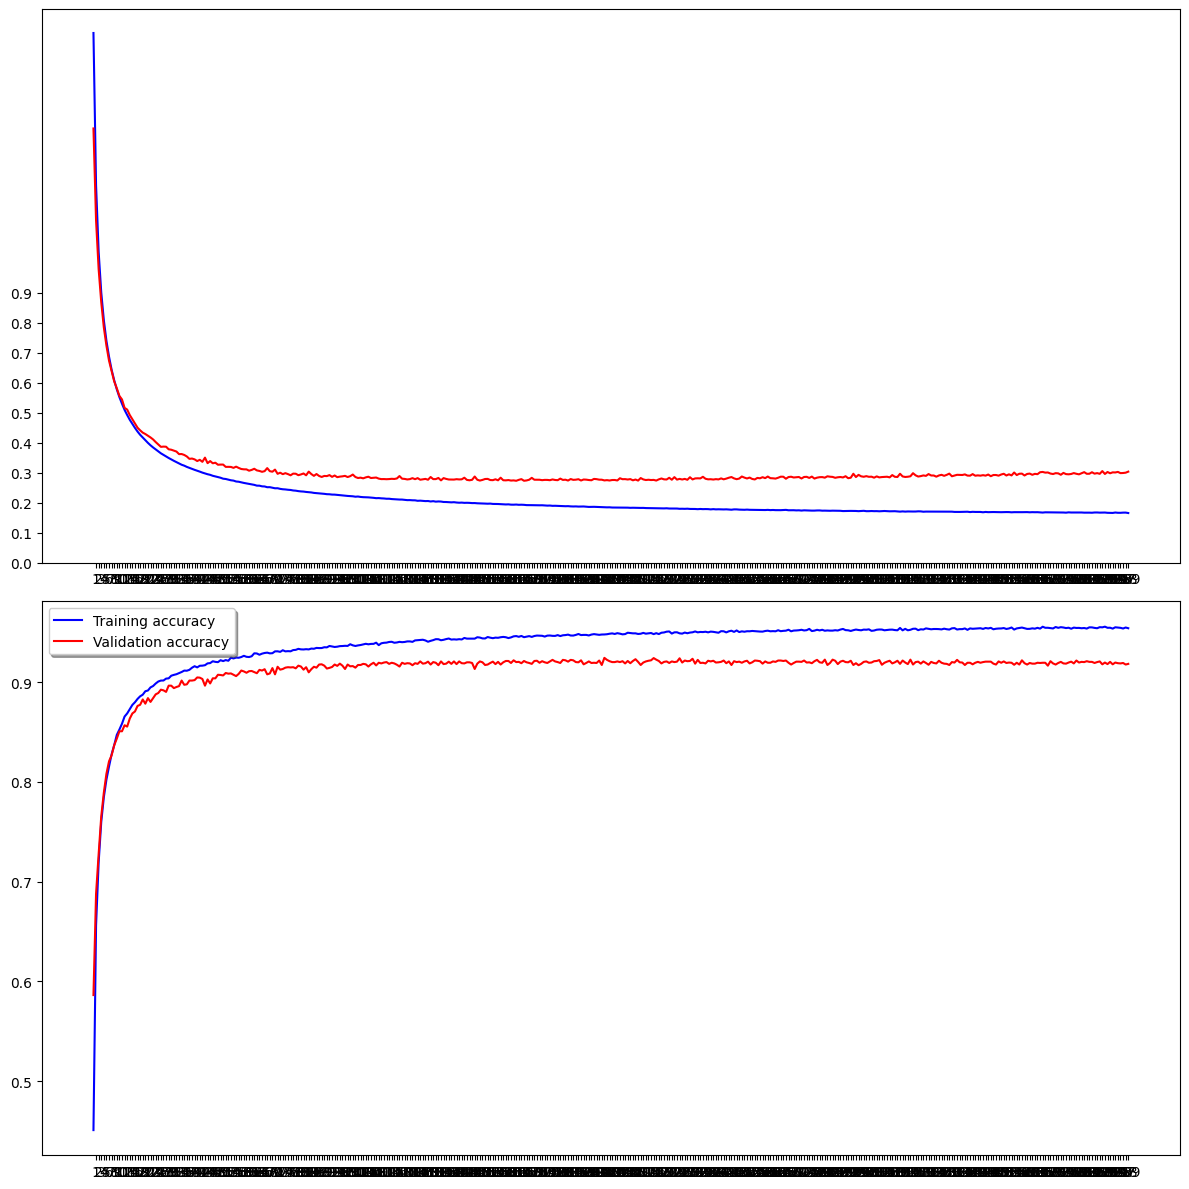

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [ ]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)


    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [ ]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
predicted_labels = MobileNetV2_model.predict(valid_mobilenetv2,verbose=1)

141/141 [==============================] - 0s 2ms/step


## Confusion Matrix

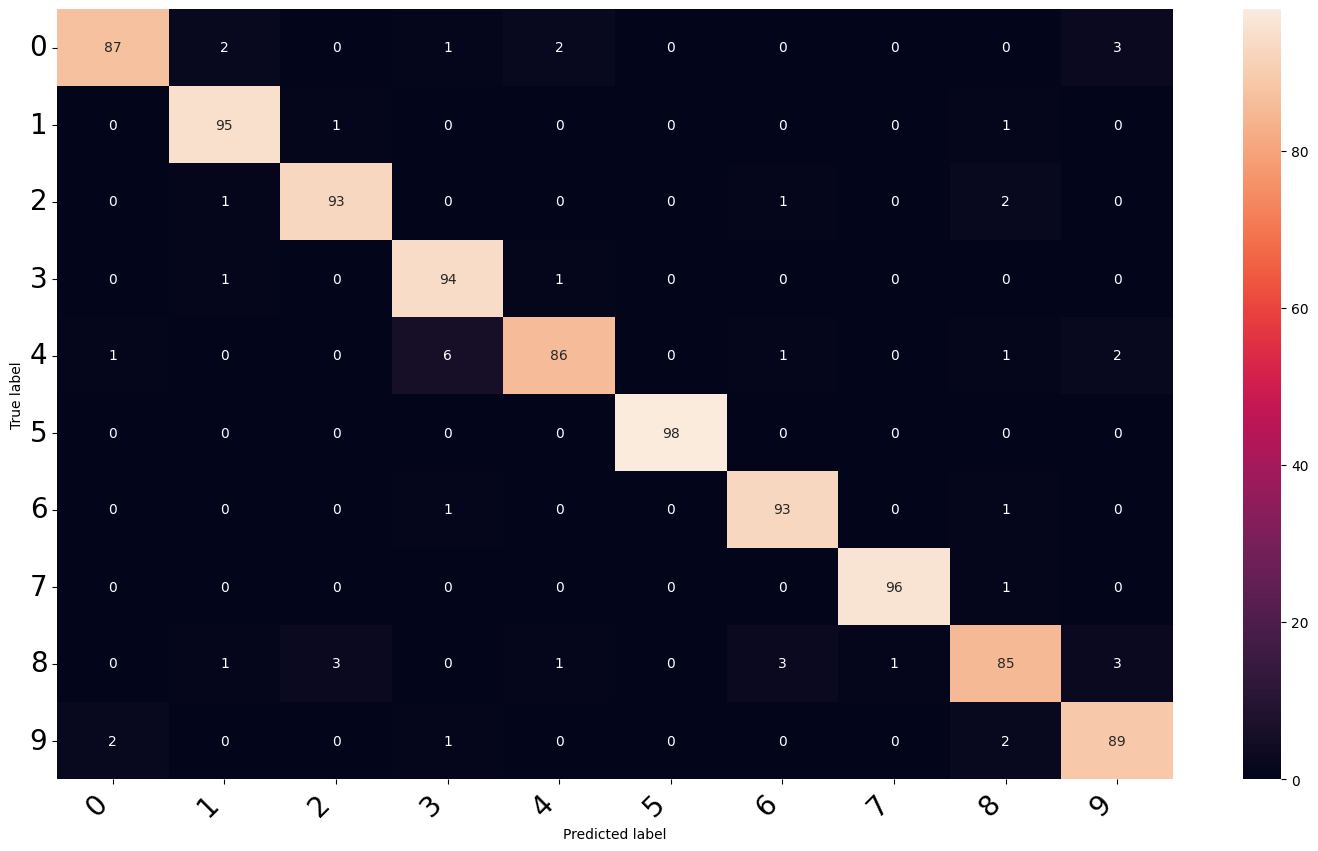

In [ ]:
print_heatmap(validation_labels,predicted_labels,class_names)

# Precision Recall F1 Score

In [ ]:
predicted_labels_class = np.argmax(predicted_labels,axis=1)
# print(predicted_labels_class[:10])
validation_labels = np.argmax(validation_labels,axis=1)

In [ ]:
accuracy = accuracy_score(validation_labels,predicted_labels_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(validation_labels, predicted_labels_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(validation_labels,predicted_labels_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(validation_labels,predicted_labels_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.918395
Precision: 0.918754
Recall: 0.918395
F1 score: 0.918233


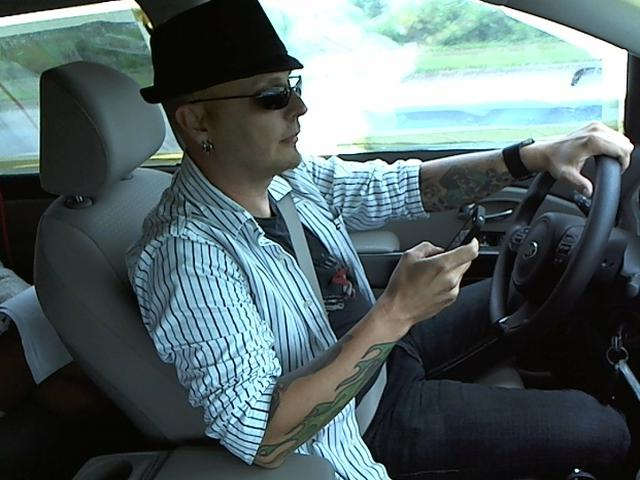

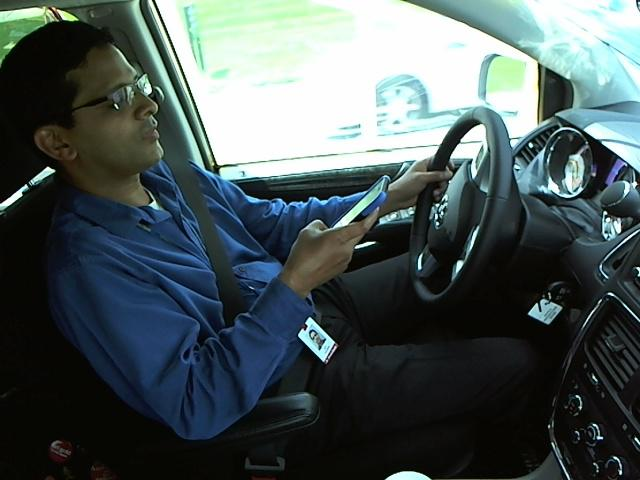

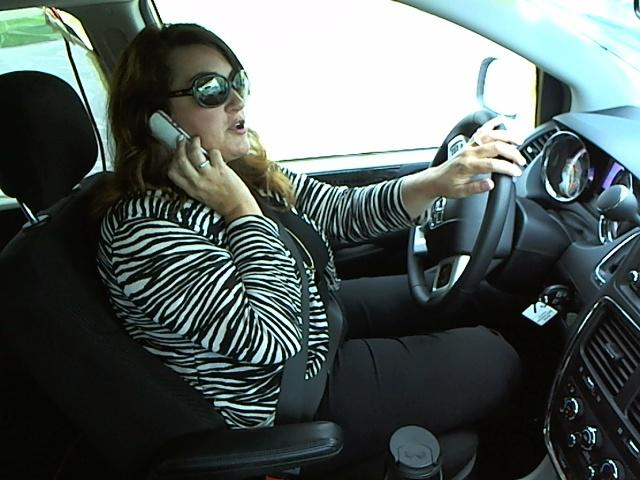

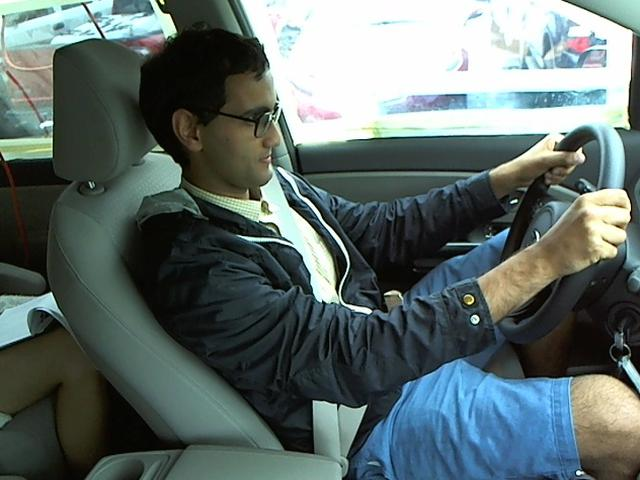

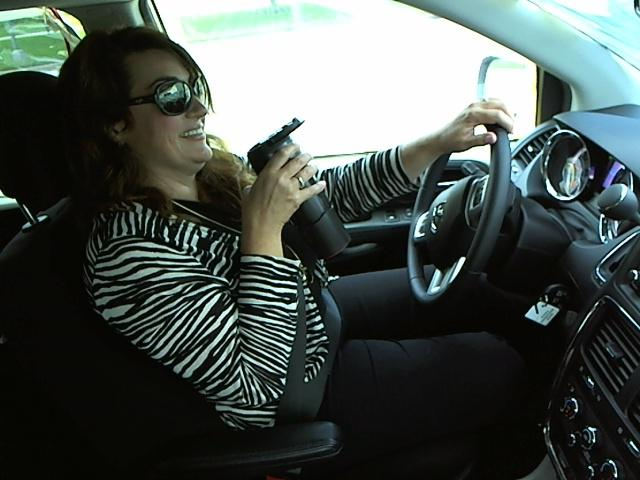

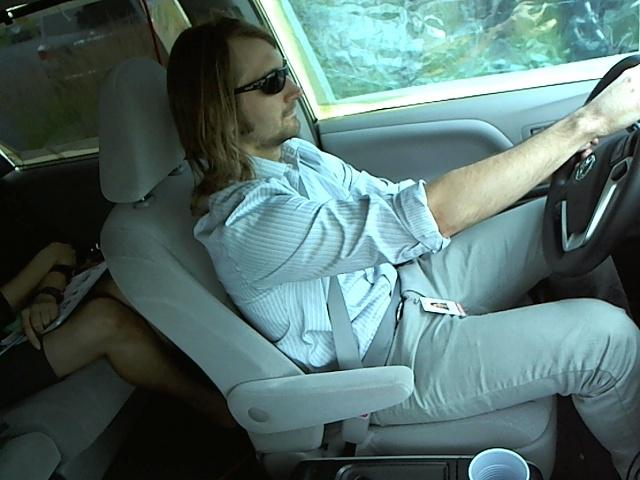

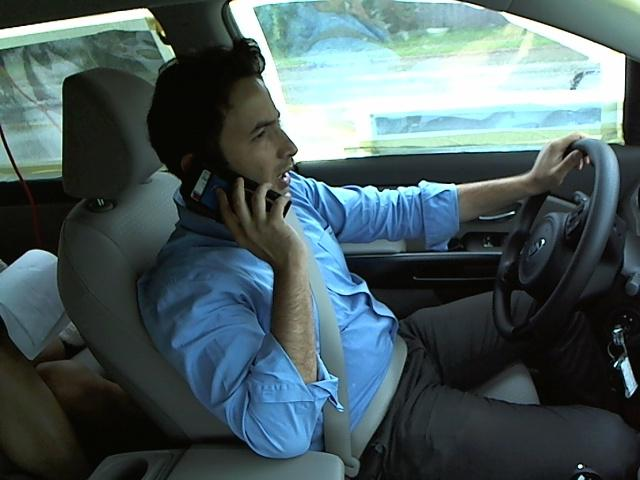

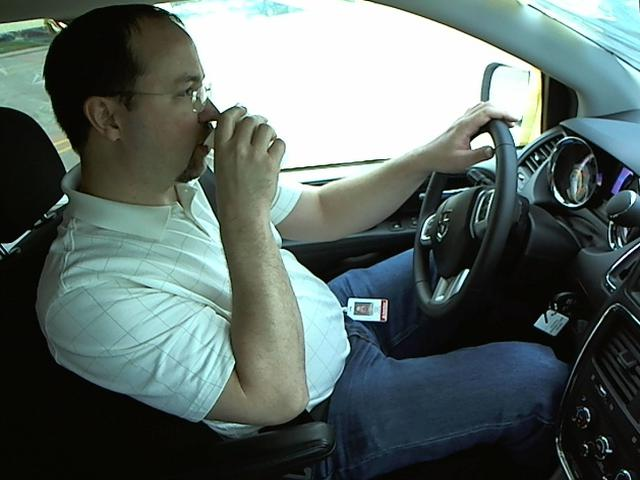

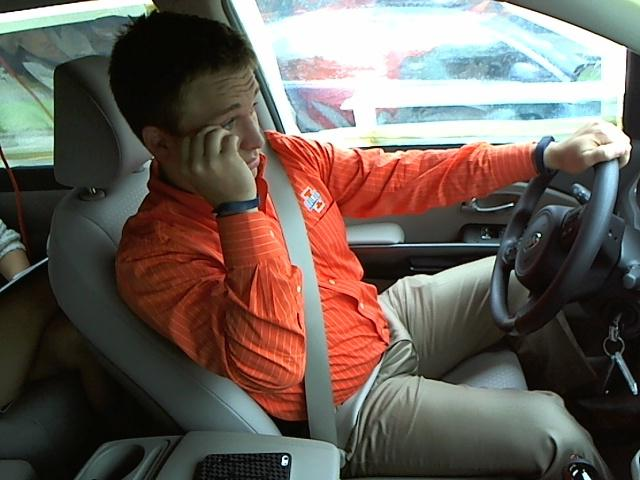

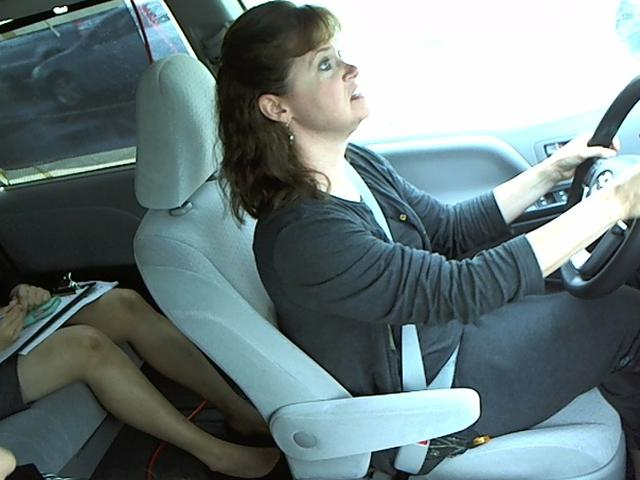


100%|██████████| 10/10 [00:00<00:00, 256.50it/s]


1/1 [==============================] - 0s 20ms/step
Image: img_61393.jpg, Predicted Class: 8
Image: img_80276.jpg, Predicted Class: 2
Image: img_35758.jpg, Predicted Class: 1
Image: img_81051.jpg, Predicted Class: 8
Image: img_23134.jpg, Predicted Class: 8
Image: img_98865.jpg, Predicted Class: 8
Image: img_2135.jpg, Predicted Class: 6
Image: img_4021.jpg, Predicted Class: 8
Image: img_71798.jpg, Predicted Class: 6
Image: img_100362.jpg, Predicted Class: 5


In [ ]:
import random
from IPython.display import Image, display

# Select 10 random images from the test dataset
random_test_images = random.sample(os.listdir(TEST_DIR), 10)

# Display the selected images
for img_name in random_test_images:
    img_path = os.path.join(TEST_DIR, img_name)
    display(Image(filename=img_path))

# Create the test dataframe for these images
test_df_subset = test_df[test_df['img'].isin(random_test_images)]

# Paths to tensor for the test subset
test_image_paths = [os.path.join(TEST_DIR, img) for img in test_df_subset['img']]
test_tensors = paths_to_tensor(test_image_paths)

# Image normalization
test_tensors = test_tensors.astype('float32') / 255 - 0.5

# Extract features using the MobileNetV2 model
test_mobilenetv2 = model.predict(test_tensors, verbose=1)

# Make predictions
predictions = MobileNetV2_model.predict(test_mobilenetv2, verbose=1)

# Display the predicted behaviors
predicted_classes = np.argmax(predictions, axis=1)

for i, img_name in enumerate(test_df_subset['img']):
    print(f"Image: {img_name}, Predicted Class: {predicted_classes[i]}")


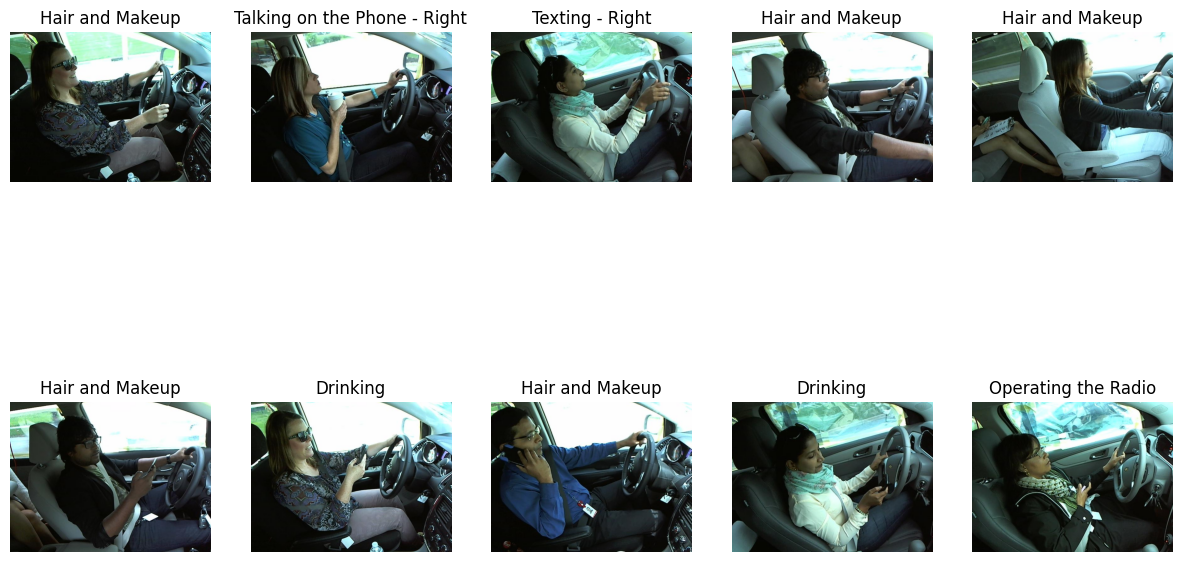

In [ ]:
import matplotlib.pyplot as plt

# Map class indices to corresponding behaviors
class_behaviors = {
    0: 'Safe Driving',
    1: 'Texting - Right',
    2: 'Talking on the Phone - Right',
    3: 'Texting - Left',
    4: 'Talking on the Phone - Left',
    5: 'Operating the Radio',
    6: 'Drinking',
    7: 'Reaching Behind',
    8: 'Hair and Makeup',
    9: 'Talking to Passenger'
}

from matplotlib import image as mpimg

# Display the selected images in a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

for i, img_name in enumerate(random_test_images):
    img_path = os.path.join(TEST_DIR, img_name)
    img = mpimg.imread(img_path)

    # Calculate subplot position
    row = i // 5
    col = i % 5

    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'{class_behaviors[predicted_classes[i]]}')

plt.show()
